# 1.Import libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sklearn
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
from fastai.vision import *
from fastai import *
from fastai.vision.data import ImageDataLoaders
from tensorflow.keras.layers import BatchNormalization, Dropout
import warnings
warnings.filterwarnings("ignore")

# 2.Load image datas

In [35]:
# load images from input dir
train_dir='D:/Project/Deep Learning/seg_train/seg_train/'
test_dir='D:/Project/Deep Learning/seg_train/seg_test/'
train_pd = pd.DataFrame(columns=['imgFilePath','class'])

for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        classes = dirname.split('/')[-1]
        train_pd = train_pd.append({'imgFilePath':path , 'class':classes}, ignore_index = True)
#Shuffle and show image file
train_pd = sklearn.utils.shuffle(train_pd)
train_pd.head(10)

,imgFilePath,class
6492,D:/Project/Deep Learning/seg_train/seg_train/g...,glacier
2149,D:/Project/Deep Learning/seg_train/seg_train/b...,buildings
2735,D:/Project/Deep Learning/seg_train/seg_train/f...,forest
11986,D:/Project/Deep Learning/seg_train/seg_train/s...,street
8215,D:/Project/Deep Learning/seg_train/seg_train/m...,mountain
10867,D:/Project/Deep Learning/seg_train/seg_train/s...,sea
10277,D:/Project/Deep Learning/seg_train/seg_train/s...,sea
9232,D:/Project/Deep Learning/seg_train/seg_train/m...,mountain
11960,D:/Project/Deep Learning/seg_train/seg_train/s...,street
7143,D:/Project/Deep Learning/seg_train/seg_train/m...,mountain


In [7]:
test_pd = pd.DataFrame(columns=['imgFilePath','class'])
#read test images
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        classes = dirname.split('/')[-1]
        test_pd = test_pd.append({'imgFilePath':path , 'class':classes}, ignore_index = True)
#Shuffle and show image file
test_pd = sklearn.utils.shuffle(test_pd)
test_pd.head(10)

,imgFilePath,class
2406,D:/Project/Deep Learning/seg_train/seg_test/se...,sea
2547,D:/Project/Deep Learning/seg_train/seg_test/st...,street
2866,D:/Project/Deep Learning/seg_train/seg_test/st...,street
2720,D:/Project/Deep Learning/seg_train/seg_test/st...,street
258,D:/Project/Deep Learning/seg_train/seg_test/bu...,buildings
2227,D:/Project/Deep Learning/seg_train/seg_test/se...,sea
106,D:/Project/Deep Learning/seg_train/seg_test/bu...,buildings
1007,D:/Project/Deep Learning/seg_train/seg_test/gl...,glacier
2662,D:/Project/Deep Learning/seg_train/seg_test/st...,street
778,D:/Project/Deep Learning/seg_train/seg_test/fo...,forest


# Data Preprocessing and Visualization

In [81]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True)
seg_train = train_datagen.flow_from_directory(train_dir,
                                              subset="training",
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                              class_mode = 'categorical')
seg_validation = train_datagen.flow_from_directory(train_dir,
                                              subset='validation',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                              class_mode = 'categorical')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [54]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical', 
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
)

Found 14034 files belonging to 6 classes.


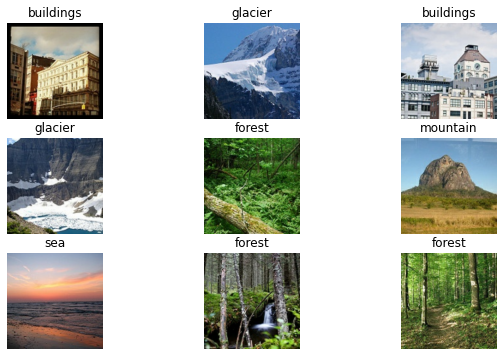

In [58]:
plt.figure(figsize=(10, 6))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

           number
class            
buildings    2191
forest       2271
glacier      2404
mountain     2512
sea          2274
street       2382


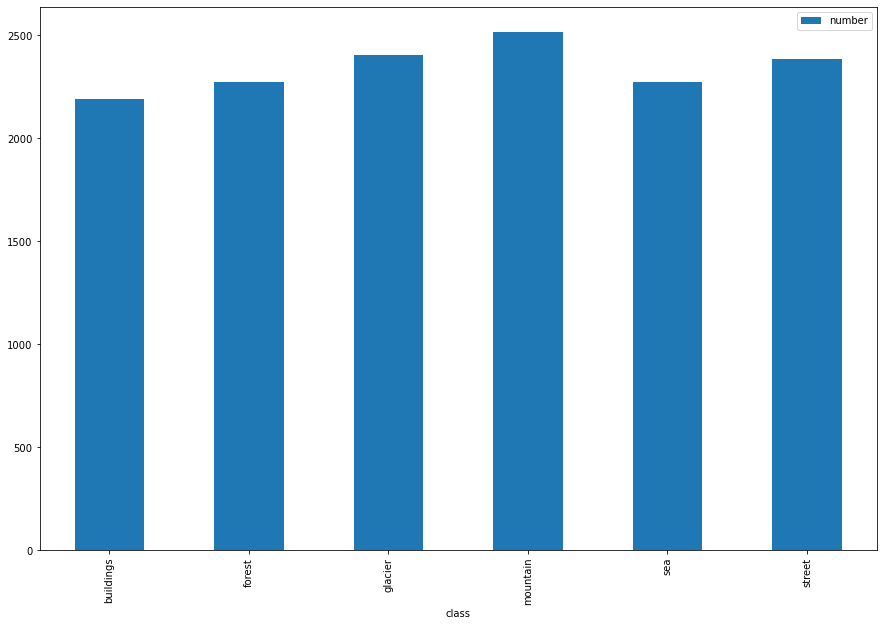

In [123]:
def showPlot(pathdir):
    images=[os.listdir(pathdir+i) for i in categories]
    df=pd.DataFrame({"number": [len(i) for i in images]}, index=categories)
    df.index.name = "class"
    df.plot(kind="bar", figsize=(15,10))
    print(df)
showPlot(train_dir)

# Basic CNN

In [87]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 41472)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [88]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [89]:
history = cnn.fit(seg_train,
          epochs=20,
          validation_data=seg_validation, 
          verbose = 1, #detail info
          steps_per_epoch=seg_train.n//seg_train.batch_size,
          validation_steps=seg_validation.n//seg_validation.batch_size
)

Epoch 1/20
350/350 [==============================] - 103s 294ms/step - loss: 1.0958 - accuracy: 0.5852 - val_loss: 0.8624 - val_accuracy: 0.6778
Epoch 2/20
350/350 [==============================] - 100s 285ms/step - loss: 0.8052 - accuracy: 0.6959 - val_loss: 0.7286 - val_accuracy: 0.7381
Epoch 3/20
350/350 [==============================] - 100s 286ms/step - loss: 0.6936 - accuracy: 0.7466 - val_loss: 0.6777 - val_accuracy: 0.7525
Epoch 4/20
350/350 [==============================] - 100s 286ms/step - loss: 0.6404 - accuracy: 0.7659 - val_loss: 0.5996 - val_accuracy: 0.7935
Epoch 5/20
350/350 [==============================] - 100s 286ms/step - loss: 0.5744 - accuracy: 0.7882 - val_loss: 0.5953 - val_accuracy: 0.7852
Epoch 6/20
350/350 [==============================] - 100s 285ms/step - loss: 0.5360 - accuracy: 0.8032 - val_loss: 0.6427 - val_accuracy: 0.7705
Epoch 7/20
350/350 [==============================] - 100s 285ms/step - loss: 0.4997 - accuracy: 0.8251 - val_loss: 0.5348 -

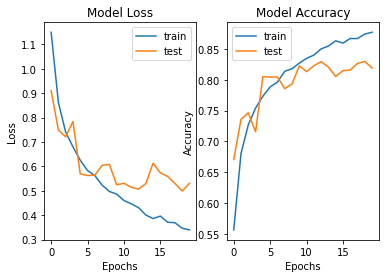

In [137]:
ax=plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
ax=plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Add Dropout

In [139]:
cnn1 = tf.keras.models.Sequential()
cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn1.add(tf.keras.layers.Flatten())
cnn1.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn1.add(Dropout(0.25))
cnn1.add(tf.keras.layers.Dense(units=6, activation='softmax'))
cnn1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 41472)             0         
                                                                 
 dense_28 (Dense)            (None, 128)             

In [121]:
cnn1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history4 = cnn1.fit(seg_train,
          epochs=20,
          validation_data=seg_validation, 
          verbose = 1, #detail info
          steps_per_epoch=seg_train.n//seg_train.batch_size,
          validation_steps=seg_validation.n//seg_validation.batch_size
)

Epoch 1/20
350/350 [==============================] - 100s 283ms/step - loss: 1.0499 - accuracy: 0.5988 - val_loss: 0.7935 - val_accuracy: 0.7170
Epoch 2/20
350/350 [==============================] - 103s 295ms/step - loss: 0.8113 - accuracy: 0.6950 - val_loss: 0.7299 - val_accuracy: 0.7302
Epoch 3/20
350/350 [==============================] - 105s 299ms/step - loss: 0.7053 - accuracy: 0.7435 - val_loss: 0.7019 - val_accuracy: 0.7403
Epoch 4/20
350/350 [==============================] - 106s 302ms/step - loss: 0.6305 - accuracy: 0.7719 - val_loss: 0.5940 - val_accuracy: 0.7859
Epoch 5/20
350/350 [==============================] - 101s 289ms/step - loss: 0.5836 - accuracy: 0.7887 - val_loss: 0.5597 - val_accuracy: 0.8085
Epoch 6/20
350/350 [==============================] - 101s 289ms/step - loss: 0.5414 - accuracy: 0.8066 - val_loss: 0.5231 - val_accuracy: 0.8139
Epoch 7/20
350/350 [==============================] - 101s 290ms/step - loss: 0.5260 - accuracy: 0.8131 - val_loss: 0.5186 -

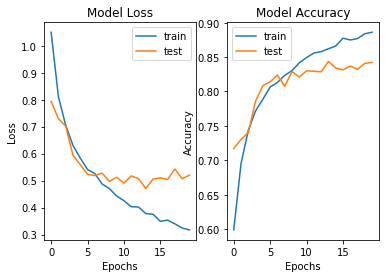

In [138]:
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#  3 LAYER

In [97]:
cnn2 = tf.keras.models.Sequential()
cnn2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Flatten())
cnn2.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn2.add(tf.keras.layers.Dense(units=6, activation='softmax'))
cnn2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 32)      

In [99]:
cnn2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history2 = cnn2.fit(seg_train,
          epochs=20,
          validation_data=seg_validation, 
          verbose = 1, #detail info
          steps_per_epoch=seg_train.n//seg_train.batch_size,
          validation_steps=seg_validation.n//seg_validation.batch_size
)

Epoch 1/20
350/350 [==============================] - 155s 440ms/step - loss: 1.0356 - accuracy: 0.5963 - val_loss: 0.8083 - val_accuracy: 0.7184
Epoch 2/20
350/350 [==============================] - 151s 431ms/step - loss: 0.7712 - accuracy: 0.7089 - val_loss: 0.7853 - val_accuracy: 0.7152
Epoch 3/20
350/350 [==============================] - 151s 432ms/step - loss: 0.6623 - accuracy: 0.7547 - val_loss: 0.8116 - val_accuracy: 0.6792
Epoch 4/20
350/350 [==============================] - 151s 430ms/step - loss: 0.5976 - accuracy: 0.7787 - val_loss: 0.5722 - val_accuracy: 0.7953
Epoch 5/20
350/350 [==============================] - 154s 440ms/step - loss: 0.5421 - accuracy: 0.7987 - val_loss: 0.5415 - val_accuracy: 0.8017
Epoch 6/20
350/350 [==============================] - 158s 452ms/step - loss: 0.4896 - accuracy: 0.8230 - val_loss: 0.5072 - val_accuracy: 0.8305
Epoch 7/20
350/350 [==============================] - 163s 466ms/step - loss: 0.4508 - accuracy: 0.8371 - val_loss: 0.4723 -

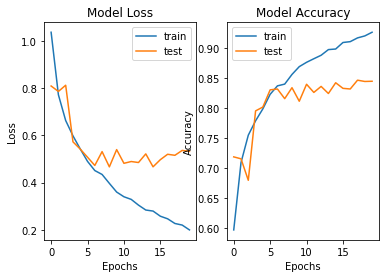

In [141]:
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# VGG16

In [142]:
from keras.applications.vgg16 import VGG16
import tensorflow.keras.layers as layers
from keras.applications.vgg19 import VGG19
vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
for layer in vgg.layers:
      layer.trainable = False
vgg.summary()      

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [108]:
model = tf.keras.models.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 6)                 774       
                                                                 
Total params: 15,764,166
Trainable params: 1,049,478
Non-trainable params: 14,714,688
_________________________________________________________________


In [109]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [110]:
history3 = model.fit(seg_train,
          epochs=20,
          validation_data=seg_validation, 
          verbose = 1, #detail info
          steps_per_epoch=seg_train.n//seg_train.batch_size,
          validation_steps=seg_validation.n//seg_validation.batch_size
)

Epoch 1/20
350/350 [==============================] - 550s 2s/step - loss: 0.5499 - accuracy: 0.8009 - val_loss: 0.4210 - val_accuracy: 0.8358
Epoch 2/20
350/350 [==============================] - 540s 2s/step - loss: 0.4080 - accuracy: 0.8500 - val_loss: 0.3899 - val_accuracy: 0.8552
Epoch 3/20
350/350 [==============================] - 542s 2s/step - loss: 0.3682 - accuracy: 0.8660 - val_loss: 0.3681 - val_accuracy: 0.8693
Epoch 4/20
350/350 [==============================] - 547s 2s/step - loss: 0.3388 - accuracy: 0.8750 - val_loss: 0.3546 - val_accuracy: 0.8754
Epoch 5/20
350/350 [==============================] - 542s 2s/step - loss: 0.3296 - accuracy: 0.8788 - val_loss: 0.3498 - val_accuracy: 0.8764
Epoch 6/20
350/350 [==============================] - 540s 2s/step - loss: 0.3161 - accuracy: 0.8811 - val_loss: 0.3522 - val_accuracy: 0.8682
Epoch 7/20
350/350 [==============================] - 542s 2s/step - loss: 0.2925 - accuracy: 0.8919 - val_loss: 0.3542 - val_accuracy: 0.8754

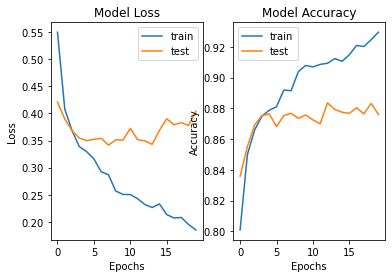

In [140]:
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()